# Exploring, cleaning, aggregating olympics results
Aim is to have an aggregated table of countries' olympic results per year (i.e. each row is a country-year, with columns for medals (gsb and total)

Results data sourced from Kaggle and seems a bit crap in some places. Could scrape from the IOC site if more serious analysis needed.

**The trouble with this data is that the teams and athlete names require lots of work to clean, so investigating other datasets instead (e.g. scraping results myself from reference sites)**

### To Do
- flag stripped medals
- Generate data (and model) for medals per event per country per year

In [9]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import os

In [12]:
path = r'C:\Users\tmais\Documents\Coding\Python\Projects\ML\OlympicsResults'
results_file = r'athlete_events.csv'

results_raw = pd.read_csv(os.path.join(path,results_file))
results_raw.head(7)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN


Each row is an individual athlete competing in an event (but it only has results for gsb)
Note that ID is a unique identifier for each individual athlete--helpful for when multiple athletes share the same name.

In [13]:
results = results_raw.reset_index()
results['games_name'] = results.apply(lambda row: '{} {}'.format(row.City, row.Year),axis=1)
results['summer'] = 0
results.loc[results.Season=='Summer', 'summer'] = 1
results.head()

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,games_name,summer
0,0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,Barcelona 1992,1
1,1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,London 2012,1
2,2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Antwerpen 1920,1
3,3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Paris 1900,1
4,4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Calgary 1988,0


<AxesSubplot:title={'center':'Top 20 countries by athlete-event count'}>

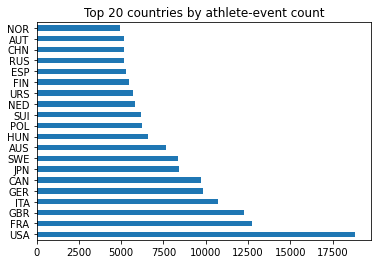

In [5]:
results.NOC.value_counts().head(20).plot(kind='barh', title='Top 20 countries by athlete-event count')

<AxesSubplot:title={'center':'Top 20 events by athlete-count'}>

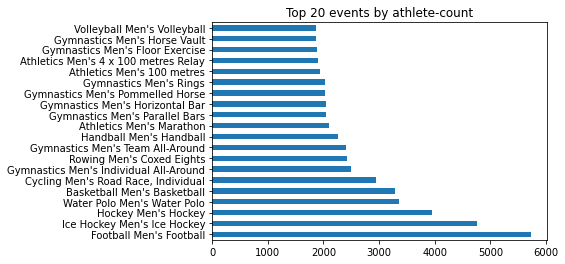

In [6]:
results.Event.value_counts().head(20).plot(kind='barh', title='Top 20 events by athlete-count')

<AxesSubplot:title={'center':'Participant counts for 10 games back from 2016 inclusive'}, ylabel='Games'>

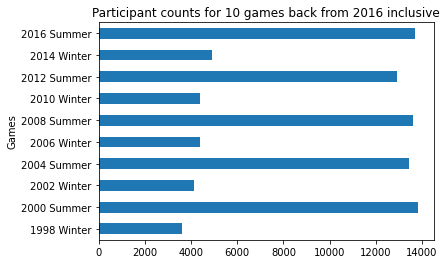

In [7]:
results.groupby('Games').count().tail(10)['ID'].plot(kind='barh', title='Participant counts for 10 games back from 2016 inclusive')

## Get list of participant teams per Olympic games


In [16]:
games_teams = results.groupby(['games_name', 'Team'])[['summer', 'Year']].first().sort_values('Year').reset_index()
games_teams.head()

,games_name,Team,summer,Year
0,Athina 1896,Australia,1,1896
1,Athina 1896,Australia/Great Britain,1,1896
2,Athina 1896,Austria,1,1896
3,Athina 1896,Denmark,1,1896
4,Athina 1896,Ethnikos Gymnastikos Syllogos,1,1896


In [20]:
games_team_count = games_teams.groupby('games_name')['Team'].count().reset_index().rename(columns={'Team': 'n_teams'})
games = games_teams.groupby('games_name')[['summer', 'Year']].first().sort_values('Year').reset_index()
games = games.merge(games_team_count, how='left', on='games_name')
games.head()

,games_name,summer,Year,n_teams
0,Athina 1896,1,1896,18
1,Paris 1900,1,1900,190
2,St. Louis 1904,1,1904,79
3,Athina 1906,1,1906,52
4,London 1908,1,1908,73


## Check whether medal amendments due to doping are implemented
Medals are sometimes stripped from athletes due to doping vialations (and awarded to 'true' winners retrospectively).

In [793]:
results[(results.Games=='2000 Summer') & (results.Sport=='Gymnastics') & (results.Sex=='F')].Event.value_counts()

Gymnastics Women's Individual All-Around    97
Gymnastics Women's Horse Vault              84
Gymnastics Women's Uneven Bars              84
Gymnastics Women's Floor Exercise           83
Gymnastics Women's Balance Beam             82
Gymnastics Women's Team All-Around          72
Name: Event, dtype: int64

In [794]:
results[(results.Games=='2000 Summer') 
        & (results.Event=="Gymnastics Women's Team All-Around") 
        & (results.Sex=='F') 
        & (results.Medal=='Bronze')].sort_values('Medal')

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
41093,41093,21181,Amy Yuen-Yee Chow (-Ho),F,22.0,155.0,44.0,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze
49151,49151,25312,Jamie Annette Dantzscher,F,18.0,152.0,49.0,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze
50078,50078,25774,Dominique Margaux Dawes (-Thompson),F,23.0,158.0,54.0,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze
147833,147833,74186,Kristen Ann Maloney,F,19.0,152.0,46.0,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze
197674,197674,99252,Mary Elise Ray,F,18.0,152.0,48.0,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze
214995,214995,107925,Tasha Schwikert-Warren,F,15.0,NaN,NaN,United States,USA,2000 Summer,2000,Summer,Sydney,Gymnastics,Gymnastics Women's Team All-Around,Bronze


Goldie Sayers 2008 Bronze isn't updated in the data, but 2000 USA women's team gymnastics is.

While it could be interesting (and more accurate/realistic for games-time predictions) to predict both initial and stripped/reallocated medals, the 'long-term' awarded medals should be considered for this analysis (i.e. adjusted for known reawarded medals due to doping).

### Import Wikipedia stripped medals data
Next step is to load <a href="https://en.wikipedia.org/wiki/List_of_stripped_Olympic_medals">Wikipedia data on stripped medals</a> to ensure data is up to date.

In [795]:
stripped_wiki_tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_stripped_Olympic_medals")
stripped = stripped_wiki_tables[1]
print(stripped.shape)
stripped.sort_values('Olympics', ascending=False).head(6)

(149, 6)


,Olympics,Athlete,Country,Medal,Event,Ref
148,2018 Winter Olympics,Curling team (Aleksandr Krushelnitckii),Olympic Athletes from Russia,NaN,"Curling, Mixed doubles",[111]
147,2016 Summer Olympics,Mikhail Aloyan,Russia,NaN,"Boxing, Men's flyweight",[110]
146,2016 Summer Olympics,Gabriel Sîncrăian,Romania,NaN,"Weightlifting, Men's 85 kg",[110]
145,2016 Summer Olympics,Serghei Tarnovschi,Moldova,NaN,"Canoeing, Men's C-1 1000 m",[109]
144,2016 Summer Olympics,Izzat Artykov,Kyrgyzstan,NaN,"Weightlifting, Men's 69 kg",[108]
142,2014 Winter Olympics,Relay team (Evgeny Ustyugov),Russia,NaN,"Biathlon, Men's relay (Y)",[107]


<AxesSubplot:title={'center':'Top 10 countries with most stripped medals since 1978'}>

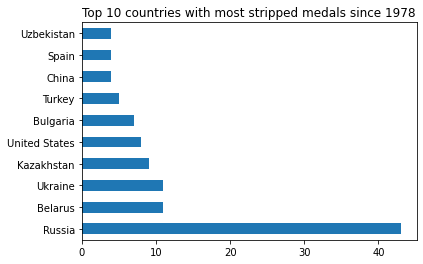

In [796]:
stripped.Country.value_counts().head(10).plot(kind='barh', title='Top 10 countries with most stripped medals since 1978')

**Event Key Letters (all should be 'NaN' in the results medal table for the stripped athletes, even for (Y)):**
- (X) medal declared vacant
- (Y) medal yet to be reallocated or declared vacant
- (Z) not due to doping; all others were due to doping offenses

Notes:
1. Pandas table scraping doesn't include the position of the stripped athletes (medals represented by image, not text), which makes the join potentially more complex (text-matching on name rather than filtering on medal)
2. The table doesn't list who the medals were reawarded to (in the cases where they were reawarded)
3. The results data doesn't include placings below Bronze (to infer updated results)

**This means that further work is needed to update the data.**

Checking stripped athletes are not awarded/listed in the results data could be done by first checking that medal awards were correct (i.e. stripped athletes don't have medals in events where recorded as stripped), then only updating those that require it.

Two potential approaches:
1. See how well the Event names match/join to the main results table
2. Manually check (doing this one as suspect that most results are correct)

Will develop algorithm to identify all athletes in results table who have had medals stripped. This will enable building models with or without the stripped medals accounted for. Updating medals after stripped medals requires more work for the reasons listed above.

The Wikipedia data includes 2018 Winter games, which isn't in the results data. This row must be dropped to before performing analysis to identify stripped athletes (to avoid searching for athletes who aren't there).

In [797]:
stripped = stripped.drop(index=stripped[stripped.Olympics.str.contains('2018')].index[0])
stripped.tail()

,Olympics,Athlete,Country,Medal,Event,Ref
143,2014 Winter Olympics,Relay team (Olga Zaitseva),Russia,NaN,"Biathlon, Women's relay (Y)",[105]
144,2016 Summer Olympics,Izzat Artykov,Kyrgyzstan,NaN,"Weightlifting, Men's 69 kg",[108]
145,2016 Summer Olympics,Serghei Tarnovschi,Moldova,NaN,"Canoeing, Men's C-1 1000 m",[109]
146,2016 Summer Olympics,Gabriel Sîncrăian,Romania,NaN,"Weightlifting, Men's 85 kg",[110]
147,2016 Summer Olympics,Mikhail Aloyan,Russia,NaN,"Boxing, Men's flyweight",[110]


### Method for fuzzy matching stripped events onto results to automate checking for stripped medals in results
1. Data cleaning on stripped to match results (e.g. sport, Games)
2. Create a compound key of Games_Country_Sport to join stripped to results ready for fuzzy matching
3. Inner join stripped onto results using Games_Country_Sport key (resulting df should include all relevant events and athletes fields)
4. Iterate (apply) through games_country_sport
5. Fuzzy Match by name (take best match)
6. Fuzzy Match by event (take best match)
7. If team sport, get indices for whole team (event-based), else get best name match for event

1. Clean stripped data to match results data

### Notes on results of checking stripped medals
1. 2018 Curling: 2018 games aren't present in the results data--drop it

In [798]:
# cleaning functions to align stripped table to results table
def sport_from_event(event):
    sport = event.split(',')[0].title()
    
    # remove hyphen from Cross-Country Skiing for join to main results
    sport = sport.replace('-', ' ')
    
    # rename 'Equestrian' as 'Equestrianism'
    sport = sport.replace('Equestrian', 'Equestrianism')
    return sport

In [799]:
# extract sport from Event name--RESULT: cleaned
stripped['Sport'] = stripped.Event.apply(sport_from_event)
stripped.Sport.unique()

array(['Modern Pentathlon', 'Judo', 'Cycling', 'Swimming',
       'Cross Country Skiing', 'Weightlifting', 'Athletics', 'Wrestling',
       'Gymnastics', 'Alpine Skiing', 'Equestrianism', 'Rowing',
       'Biathlon', 'Shooting', 'Canoeing', 'Bobsleigh', 'Boxing'],
      dtype=object)

In [800]:
# check that Sports join correctly between tables (i.e. no NaNs)--RESULT: cleaned
stripped.Sport.value_counts().reset_index().merge(results.Sport.value_counts().reset_index(), 
                                                  left_on='index', 
                                                  right_on='index', 
                                                  how='left')

,index,Sport_x,Sport_y
0,Weightlifting,50,3937
1,Athletics,50,38624
2,Wrestling,13,7154
3,Cross Country Skiing,9,9133
4,Cycling,5,10859
5,Biathlon,3,4893
6,Equestrianism,3,6344
7,Modern Pentathlon,2,1677
8,Bobsleigh,2,3058
9,Canoeing,2,6171


In [801]:
# check that Countries join correctly between tables (i.e. no NaNs)--RESULT: only 2018 issue with Russia (dropping rows from results)
stripped.Country.value_counts().reset_index().merge(results.Team.value_counts().reset_index(), 
                                                    left_on='index', 
                                                    right_on='index', 
                                                    how='left')

,index,Country,Team
0,Russia,43,4922
1,Belarus,11,1783
2,Ukraine,11,2511
3,Kazakhstan,9,1429
4,United States,8,17847
5,Bulgaria,7,3518
6,Turkey,5,1353
7,China,4,4975
8,Spain,4,5224
9,Uzbekistan,4,491


In [802]:
# clean games-year--RESULT: cleaned
stripped['Olympics'] = stripped['Olympics'].str.replace(' Olympics', '')
stripped.Olympics.unique()

array(['1968 Summer', '1972 Summer', '1976 Winter', '1976 Summer',
       '1984 Summer', '1988 Summer', '1992 Summer', '2000 Summer',
       '2002 Winter', '2004 Summer', '2006 Winter', '2008 Summer',
       '2012 Summer', '2014 Winter', '2016 Summer'], dtype=object)

2. Create compound key for join

In [803]:
stripped['games_country_sport'] = stripped.Olympics + '_' + stripped.Country + '_' + stripped.Sport
stripped.head(2)

,Olympics,Athlete,Country,Medal,Event,Ref,Sport,games_country_sport
0,1968 Summer,Modern Pentathlon team (Hans-Gunnar Liljenwall),Sweden,NaN,"Modern pentathlon, Team",[11],Modern Pentathlon,1968 Summer_Sweden_Modern Pentathlon
1,1972 Summer,Bakhvain Buyadaa,Mongolia,NaN,"Judo, Men's 63 kg (X)",[12],Judo,1972 Summer_Mongolia_Judo


In [804]:
results['games_country_sport'] = results.Games + '_' + results.Team + '_' + results.Sport
results.head(2)

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,games_country_sport
0,0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,1992 Summer_China_Basketball
1,1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,2012 Summer_China_Judo


3. Inner-join tables for fuzzy matching

In [827]:
results_fields = ['games_country_sport', 'index', 'ID', 'Name', 'Sex', 'Team', 'Games', 'Sport', 'Event', 'Medal']
stripped_fields = ['games_country_sport', 'Olympics', 'Athlete', 'Country', 'Event']

# results_stripped = results.loc[~results.Medal.isna(), results_fields].merge(stripped[stripped_fields], 
#                                                                             how='inner',
#                                                                             on='games_country_sport',
#                                                                             suffixes=['_results', '_stripped'])

results_stripped = results[results_fields].merge(stripped[stripped_fields], 
                                                 how='inner',
                                                 on='games_country_sport',
                                                 suffixes=['_results', '_stripped'])

results_stripped[results_stripped.games_country_sport=='2012 Summer_Russia_Athletics'].shape

(1166, 14)

In [806]:
results[results.games_country_sport.isin(stripped.games_country_sport)].shape

(2262, 17)

In [807]:
results_stripped.shape

(5589, 14)

In [808]:
len(stripped.games_country_sport.unique())

83

In [809]:
stripped.shape

(148, 8)

4. Fuzzy-match on names and events (will use partial ratio because some names are listed in stripped table when part of team)

Testing best fuzzy-match approaches

In [811]:
str1 = "Denis Sergeyevich Alekseyev"
str2 = "Relay team (Denis Alexeev)"
print('rat: ',fuzz.ratio(str1, str2))
print('pr:  ',fuzz.partial_ratio(str1, str2))
print('tsortr: ',fuzz.token_sort_ratio(str1, str2))
print('tsetr: ',fuzz.token_set_ratio(str1, str2))

rat:  45
pr:   42
tsortr:  59
tsetr:  59


In [812]:
str1 = "Olga Alekseyevna Zaytseva (-Augustin)"
str2 = "Olga Pyleva"
print('rat: ',fuzz.ratio(str1, str2))
print('pr:  ',fuzz.partial_ratio(str1, str2))
print('tsortr: ',fuzz.token_sort_ratio(str1, str2))
print('tsetr: ',fuzz.token_set_ratio(str1, str2))

rat:  38
pr:   64
tsortr:  40
tsetr:  53


In [813]:
str1 = "Olga Valeryevna Pylyova-Medvedtseva (Zamorozova-)"
str2 = "Olga Pyleva"
print('rat: ',fuzz.ratio(str1, str2))
print('pr:  ',fuzz.partial_ratio(str1, str2))
print('tsortr: ',fuzz.token_sort_ratio(str1, str2))
print('tsetr: ',fuzz.token_set_ratio(str1, str2))

rat:  37
pr:   64
tsortr:  35
tsetr:  53


Partial Ratio algorithm seems best for names

In [814]:
str1 = "Canoeing Men's Canadian Singles, 200 metres"
str2 = "Canoeing, Men's C-1 1000 m"
print('rat: ',fuzz.ratio(str1, str2))
print('pr:  ',fuzz.partial_ratio(str1, str2))
print('tsortr: ',fuzz.token_sort_ratio(str1, str2))
print('tsetr: ',fuzz.token_set_ratio(str1, str2))

rat:  61
pr:   65
tsortr:  57
tsetr:  72


In [815]:
str1 = "Wrestling Men's Super-Heavyweight, Greco-Roman"
str2 = "Wrestling, Men's Greco-Roman +100 kg"
print('rat: ',fuzz.ratio(str1, str2))
print('pr:  ',fuzz.partial_ratio(str1, str2))
print('tsortr: ',fuzz.token_sort_ratio(str1, str2))
print('tsetr: ',fuzz.token_set_ratio(str1, str2))

rat:  66
pr:   50
tsortr:  73
tsetr:  89


Token set ratio seems best for events

In [816]:
def fuzz_event_score(Sport, str1, str2):
    '''Remove the sport from the event names for matching to increase the matching effectiveness (sports will always match)'''
    
    # replace sport with blank and remove comma-space
    replacements = {Sport: '',
                    ', ': ''}
    
    for replacement in replacements:
        str1 = str1.replace(replacement, replacements[replacement])
        str2 = str2.replace(replacement, replacements[replacement])
    
    # use token sort ratio as proved best for matching events
    return fuzz.token_set_ratio(str1, str2)

In [828]:
results_stripped['name_match_score'] = results_stripped.apply(lambda row: fuzz.partial_ratio(row['Name'].lower(), row['Athlete'].lower()), 
                                                                axis=1)
results_stripped['event_match_score'] = results_stripped.apply(lambda row: fuzz_event_score(row['Sport'],
                                                                                                 row['Event_results'], 
                                                                                                 row['Event_stripped']), 
                                                                    axis=1)
results_stripped.sort_values('event_match_score', ascending=False).head(2)

,games_country_sport,index,ID,Name,Sex,Team,Games,Sport,Event_results,Medal,Olympics,Athlete,Country,Event_stripped,name_match_score,event_match_score
109,2008 Summer_Russia_Athletics,24282,12731,Anna Andreyevna Bogdanova,F,Russia,2008 Summer,Athletics,Athletics Women's Heptathlon,NaN,2008 Summer,Tatyana Chernova,Russia,"Athletics, Women's heptathlon",50,100
2552,2000 Summer_United States_Athletics,110167,55703,"Marion Lois Jones (-Hunter, -Montgomery, -Thom...",F,United States,2000 Summer,Athletics,Athletics Women's Long Jump,NaN,2000 Summer,Marion Jones,United States,"Athletics, Women's long jump",75,100


In [829]:
def find_the_cheats(stripped_row):
    ''' Filters results_stripped based on the stripped row inputted, then uses best combination of matched name and event 
    to find the indices for the row in results. For team events, all athletes on the team are found.'''
    
    # filter by known games_country_sport, athlete, event (from stripped row)
    mask1 = results_stripped.games_country_sport==stripped_row.games_country_sport
    mask2 = results_stripped.Athlete==stripped_row.Athlete
    mask3 = results_stripped.Event_stripped==stripped_row.Event
    df = results_stripped[mask1 & mask2 & mask3]
    
    if df.shape[0] > 0:
        # find the best athlete and event match scores
        name_match_max = df.name_match_score.max()
        event_match_max = df.event_match_score.max()
        
        # filter down to best matches. If multiple, print stripped input and take top row
        mask_name = df.name_match_score==name_match_max
        mask_event = df.event_match_score==event_match_max

        if name_match_max > event_match_max:
            df_filtered = df[mask_name].sort_values('event_match_score').iloc[-1]
        else:
            df_filtered = df[mask_event].sort_values('name_match_score').iloc[-1]

        # if team event, extract all-team indices, else extract athlete index with the best name match from the event
        team_checks = ['team', 'two-man', 'four-man']
        athlete = stripped_row.Athlete
        if any(team_check in athlete.lower() for team_check in team_checks):
            idx = df[(df.Event_results==df_filtered.Event_results) & (df.Team==df_filtered.Team)]['index'].to_list()
        else:
            idx = df_filtered['index']

        # add column to track stripped medals if required
        stripped_col_name = 'stripped'
        if stripped_col_name not in results:
            results[stripped_col_name] = 0

        # flag all rows with stripped medals using indices
        results.loc[idx, stripped_col_name] = 1
        
        # return the indices for ref
        return idx

In [830]:
results['stripped'] = 0
stripped['idx'] = stripped.apply(lambda row: find_the_cheats(row), axis=1)

In [831]:
stripped.head()

,Olympics,Athlete,Country,Medal,Event,Ref,Sport,games_country_sport,idx
0,1968 Summer,Modern Pentathlon team (Hans-Gunnar Liljenwall),Sweden,NaN,"Modern pentathlon, Team",[11],Modern Pentathlon,1968 Summer_Sweden_Modern Pentathlon,"[67992, 105173, 139079]"
1,1972 Summer,Bakhvain Buyadaa,Mongolia,NaN,"Judo, Men's 63 kg (X)",[12],Judo,1972 Summer_Mongolia_Judo,12967
2,1972 Summer,Cycling team (Aad van den Hoek),Netherlands,NaN,"Cycling, Men's team time trial (X)",[13],Cycling,1972 Summer_Netherlands_Cycling,"[53695, 128599, 193127, 248354]"
3,1972 Summer,Jaime Huélamo,Spain,NaN,"Cycling, Men's individual road race (X)",[13],Cycling,1972 Summer_Spain_Cycling,100473
4,1972 Summer,Rick DeMont,United States,NaN,"Swimming, Men's 400 m freestyle",[8],Swimming,1972 Summer_United States_Swimming,53637


In [832]:
results[results.stripped==1].sort_values('Games').head()

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,games_country_sport,stripped
139079,139079,69868,Hans-Gunnar Liljenwall,M,27.0,188.0,74.0,Sweden,SWE,1968 Summer,1968,Summer,Mexico City,Modern Pentathlon,Modern Pentathlon Men's Team,NaN,1968 Summer_Sweden_Modern Pentathlon,1
67992,67992,34729,Bjrn Bernt Ewald Ferm,M,24.0,180.0,72.0,Sweden,SWE,1968 Summer,1968,Summer,Mexico City,Modern Pentathlon,Modern Pentathlon Men's Team,NaN,1968 Summer_Sweden_Modern Pentathlon,1
105173,105173,53227,Hans Olov Dan Jacobson,M,21.0,180.0,71.0,Sweden,SWE,1968 Summer,1968,Summer,Mexico City,Modern Pentathlon,Modern Pentathlon Men's Team,NaN,1968 Summer_Sweden_Modern Pentathlon,1
248354,248354,124333,"Adriaan ""Aad"" van den Hoek",M,20.0,186.0,77.0,Netherlands,NED,1972 Summer,1972,Summer,Munich,Cycling,Cycling Men's 100 kilometres Team Time Trial,NaN,1972 Summer_Netherlands_Cycling,1
53637,53637,27506,"Richard James ""Rick"" DeMont",M,16.0,180.0,69.0,United States,USA,1972 Summer,1972,Summer,Munich,Swimming,Swimming Men's 400 metres Freestyle,NaN,1972 Summer_United States_Swimming,1


### Export stripped results data for inspection

In [826]:
stripped_results_filename = r'stripped_results.csv'
cols = ['Games', 'Name', 'Team', 'Medal', 'Event', 'stripped']
results.loc[results.stripped==1, cols].sort_values(['Games', 'Team']).to_csv(os.path.join(path, stripped_results_filename))
print('Done')

Done


## Aggregating data to medals per country per event
Two approaches here:
1. Not considering stripped medals (some are stripped in the results data already)
2. Considering stripped medals (currently no replacement/update of other medals as not all placings included in the data. Could scrape IOC website for better results data).

**Note:** Medal tables are typically considered by event (not individuals), so the groupby needs to be event based and not sum all individual athlete medals per event

### Not considering stripped medals

Plan
1. one-hot encode medals column for results and join back on
2. groupby games, team, event using max as the aggregation function (consider required columns here)
3. reset index..?

Issues
- What if two athletes from the same nation tie for a medal? The max-groupby only counts one medal per games/event/team combination...

In [834]:
results.head(2)

,index,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,games_country_sport,stripped
0,0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,1992 Summer_China_Basketball,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,2012 Summer_China_Judo,0


In [835]:
results.Medal.value_counts()

Gold      13372
Bronze    13295
Silver    13116
Name: Medal, dtype: int64

1. One-Hot Encode Medals column

In [841]:
keep_cols = ['Team', 'NOC', 'Games', 'City', 'Sport', 'Event', 'Medal_Gold', 'Medal_Silver', 'Medal_Bronze']
gsb = pd.get_dummies(results, columns=['Medal'])[keep_cols]
gsb[gsb.Medal_Gold==1].head(2)

,Team,NOC,Games,City,Sport,Event,Medal_Gold,Medal_Silver,Medal_Bronze
3,Denmark/Sweden,DEN,1900 Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1,0,0
42,Finland,FIN,1948 Summer,London,Gymnastics,Gymnastics Men's Team All-Around,1,0,0


2. Group by Games, Team, Event (what about tied medals by the same team??)

In [846]:
len(gsb.Event.unique())

765

In [848]:
event_grouped = gsb.groupby(['Games', 'Team', 'Event']).max().reset_index()
event_grouped.head()

,Games,Team,Event,NOC,City,Sport,Medal_Gold,Medal_Silver,Medal_Bronze
0,1896 Summer,Australia,"Athletics Men's 1,500 metres",AUS,Athina,Athletics,1,0,0
1,1896 Summer,Australia,Athletics Men's 800 metres,AUS,Athina,Athletics,1,0,0
2,1896 Summer,Australia,Athletics Men's Marathon,AUS,Athina,Athletics,0,0,0
3,1896 Summer,Australia,Tennis Men's Singles,AUS,Athina,Tennis,0,0,0
4,1896 Summer,Australia/Great Britain,Tennis Men's Doubles,GBR,Athina,Tennis,0,0,1


In [850]:
team_grouped = event_grouped.groupby(['Games', 'Team']).sum().reset_index()
team_grouped['Medal_Total'] = team_grouped.Medal_Gold + team_grouped.Medal_Silver + team_grouped.Medal_Bronze
team_grouped.head()

,Games,Team,Medal_Gold,Medal_Silver,Medal_Bronze,Medal_Total
0,1896 Summer,Australia,2,0,0,2
1,1896 Summer,Australia/Great Britain,0,0,1,1
2,1896 Summer,Austria,2,1,2,5
3,1896 Summer,Denmark,1,2,3,6
4,1896 Summer,Ethnikos Gymnastikos Syllogos,0,0,1,1


In [854]:
[print(team) for team in team_grouped.Team.unique()]

Australia
Australia/Great Britain
Austria
Denmark
Ethnikos Gymnastikos Syllogos
France
Germany
Great Britain
Great Britain/Germany
Greece
Greece-1
Greece-2
Greece-3
Hungary
Italy
Sweden
Switzerland
United States
A North American Team
Alcyon-6
Alcyon-7
Amateur Athletic Association
Amulet-3
Amulet-7
Argentina
Ariette-10
Ariette-8
Aschenbrodel
Austria-1
BLO Polo Club, Rugby
Baby-1
Baby-9
Bagatelle Polo Club, Paris
Belgium
Belgium-1
Belgium-2
Bohemia
Bohemia/Great Britain
Bona Fide
Brazil
Brussels Swimming and Water Polo Club
Brynhild-2
C.V.A.-14
C.V.A.-7
Canada
Carabinier-15
Carabinier-5
Cercle Nautique de Reims-4
Cercle de l'Aviron Roubaix-4
Cicely-1
Cinara-13
Club Nautique de Dieppe-5
Club Nautique de Franais-1
Club Nautique de Lyon-2
Colette-10
Colette-12
Compigne Polo Club
Crabe I-11
Crabe I-2
Crabe I-3
Crabe II-1
Crabe II-12
Crabe II-4
Crocodile-11
Crocodile-13
Cuba
Demi-Mondaine-15
Demi-Mondaine-17
Denmark/Sweden
Deutscher Schwimm Verband Berlin
Devon and Somerset Wanderers
Dick-8
D

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,